<a href="https://colab.research.google.com/github/GabeMaldonado/JupyterNotebooks/blob/master/VARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VECTOR AUTOREGRESSION MOVING AVERAGE (VARMA)

VARMA is basically a VAR model which adds a Moving Average component. 

In [0]:
import pandas as pd
import numpy as np
%matplotlib inline

In [7]:
pip install pmdarima

      Successfully uninstalled scipy-1.3.0


In [0]:
# import stats models forecasting tools

from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse

In [0]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

##  Load Data and Perform EDA
M2SLMoneyStock and PCEPersonalSpending dataframes.

In [0]:
# Load Moneystock dataset

df1 = pd.read_csv('M2SLMoneyStock.csv', index_col = 0, parse_dates = True)

# Set frequency
df1.index.freq = 'MS'

In [0]:
# Load PCE dataset

df2 = pd.read_csv('PCEPersonalSpending.csv', index_col = 0, parse_dates = True)

# Set freqeuncy
df2.index.freq = 'MS'

In [12]:
# Display df's heads
df1.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [13]:
df2.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [14]:
# Combine both dataframes using join
# assign it to a new df to make changes permanent

df = df1.join(df2)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [15]:
# Get data on df
df.describe()

,Money,Spending
count,252.000000,252.000000
mean,6978.151190,8562.311905
std,2554.325115,2231.933352
min,3489.900000,4850.800000
25%,4732.875000,6682.125000
50%,6507.400000,8777.150000
75%,8699.700000,10262.925000
max,12335.900000,12469.100000


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 1995-01-01 to 2015-12-01
Freq: MS
Data columns (total 2 columns):
Money       252 non-null float64
Spending    252 non-null float64
dtypes: float64(2)
memory usage: 15.9 KB


In [17]:
df.shape

(252, 2)

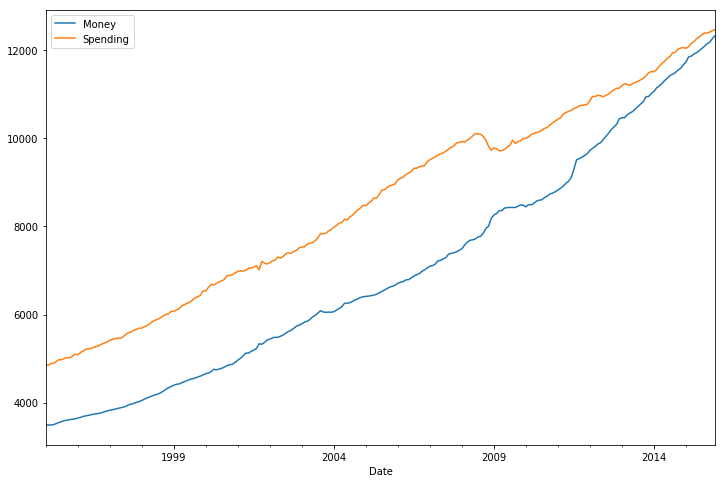

In [18]:
# Visualize Data

df.plot(figsize = (12,8));

### Test Data for Stationary and Perform Transformations

In [0]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [20]:
# run adf on the 'Money' column of dataframe

adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [21]:
# Run adf on the 'Spending' column of dataframe
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [22]:
auto_arima(df['Money'], maxiter=1000)

ARIMA(callback=None, disp=0, maxiter=1000, method=None, order=(1, 2, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend=None,
      with_intercept=True)

In [23]:
auto_arima(df['Spending'], maxiter=1000)

ARIMA(callback=None, disp=0, maxiter=1000, method=None, order=(1, 1, 2),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend=None,
      with_intercept=True)

VARMA(1, 2) has been recommended. 

In [24]:
df_transformed = df.diff().diff()
df_transformed = df_transformed.dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [25]:
len(df_transformed)

250

### Train-Test-Split
As previous, we'd use 12 months.


In [0]:
num_of_obs = 12
train, test = df_transformed[:-num_of_obs], df_transformed[-num_of_obs:]

In [27]:
print(train.shape)
print(train.shape)

(238, 2)
(238, 2)


### Fit VARMA(1,2) Model

In [28]:
model = VARMAX(train, order=(1,2), trend='c')
results = model.fit(maxiter = 1000, disp=False)
results.summary()

Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.309
,+ intercept,AIC,4606.618
Date:,"Sun, 21 Jul 2019",BIC,4665.646
Time:,15:26:32,HQIC,4630.407
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (Q):,"68.08, 28.09",Jarque-Bera (JB):,"566.68, 126.74"
Prob(Q):,"0.00, 0.92",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.68, 2.89",Skew:,"1.36, -0.35"


### Forecast Next 12 Values
It is much simpler to pass VARMAX.forecast() as it doesn not require thatr we pass the number of previous observations as in the VAR model.

In [29]:
df_forecast = results.forecast(12)
df_forecast

,Money,Spending
2015-01-01,-12.191798,37.365311
2015-02-01,-11.205112,-5.136945
2015-03-01,1.885681,-0.115447
2015-04-01,-1.831952,-0.365111
2015-05-01,1.318704,0.279979
2015-06-01,-0.579469,-0.055138
2015-07-01,0.659448,0.172887
2015-08-01,-0.132621,0.028596
2015-09-01,0.376422,0.121573
2015-10-01,0.049707,0.061938


### Reversing Differences
The forecasted values were obtained with second order differences. To effectively compare against the original data, we have to reverse the differences. To achieve this, we take the most recent value of the original seried and add it to a cummulative sum of forecasted values.

In [0]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-num_of_obs-1]-df['Money'].iloc[-num_of_obs-2]) + df_forecast['Money'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-num_of_obs-1] + df_forecast['Money'].cumsum()

In [0]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-num_of_obs-1]-df['Spending'].iloc[-num_of_obs-2]) + df_forecast['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-num_of_obs-1] + df_forecast['Spending'].cumsum()

In [32]:
df_forecast

,Money,Spending,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-12.191798,37.365311,66.408202,11657.908202,47.965311,12099.365311
2015-02-01,-11.205112,-5.136945,55.203090,11646.703090,42.828367,12094.228367
2015-03-01,1.885681,-0.115447,57.088771,11648.588771,42.712920,12094.112920
2015-04-01,-1.831952,-0.365111,55.256819,11646.756819,42.347809,12093.747809
2015-05-01,1.318704,0.279979,56.575523,11648.075523,42.627787,12094.027787
2015-06-01,-0.579469,-0.055138,55.996054,11647.496054,42.572649,12093.972649
2015-07-01,0.659448,0.172887,56.655502,11648.155502,42.745537,12094.145537
2015-08-01,-0.132621,0.028596,56.522880,11648.022880,42.774133,12094.174133
2015-09-01,0.376422,0.121573,56.899303,11648.399303,42.895706,12094.295706
2015-10-01,0.049707,0.061938,56.949010,11648.449010,42.957644,12094.357644


In [33]:
pd.concat([df.iloc[-12:], df_forecast[['MoneyForecast', 'SpendingForecast']]], axis = 1)

,Money,Spending,MoneyForecast,SpendingForecast
Date,,,,
2015-01-01,11733.2,12046.0,11657.908202,12099.365311
2015-02-01,11852.4,12082.4,11646.703090,12094.228367
2015-03-01,11868.8,12158.3,11648.588771,12094.112920
2015-04-01,11916.1,12193.8,11646.756819,12093.747809
2015-05-01,11947.6,12268.1,11648.075523,12094.027787
2015-06-01,11993.1,12308.3,11647.496054,12093.972649
2015-07-01,12045.3,12355.4,11648.155502,12094.145537
2015-08-01,12096.8,12394.0,11648.022880,12094.174133
2015-09-01,12153.8,12392.8,11648.399303,12094.295706


### Visualize Results

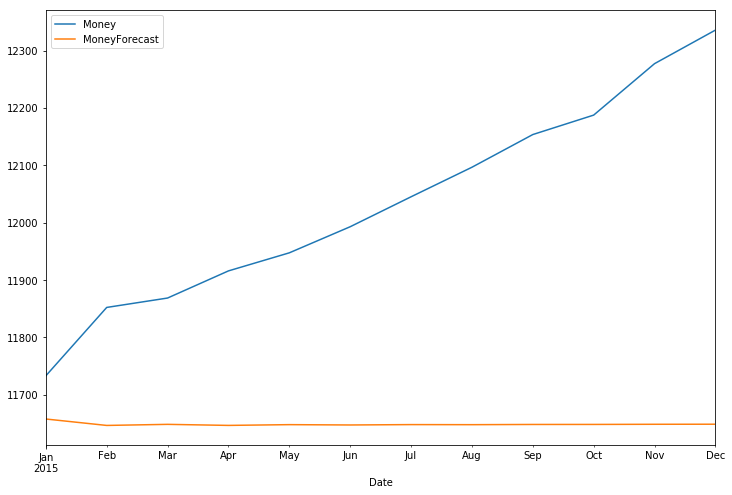

In [34]:
df['Money'][-num_of_obs:].plot(figsize = (12, 8), legend = True).autoscale(axis = 'x', tight = True);
df_forecast['MoneyForecast'].plot(legend = True);

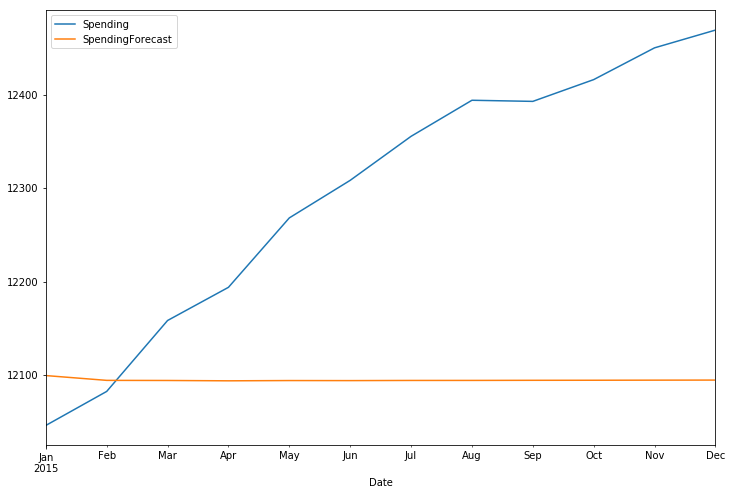

In [35]:
df['Spending'][-num_of_obs:].plot(figsize = (12, 8), legend = True).autoscale(axis = 'x', tight = True);
df_forecast['SpendingForecast'].plot(legend = True);

### Evaluate the model

&nbsp;&nbsp;&nbsp;&nbsp;$RMSE = \sqrt{{\frac 1 L} \sum\limits_{l=1}^L (y_{T+l} - \hat y_{T+l})^2}$<br><br>
where $T$ is the last observation period and $l$ is the lag.

In [36]:
RMSE1 = rmse(df['Money'][-num_of_obs:], df_forecast['MoneyForecast'])
print(f'Money VAR(5) RMSE: {RMSE1:.3f}')

Money VAR(5) RMSE: 423.363


In [37]:
RMSE2 = rmse(df['Spending'][-num_of_obs:], df_forecast['SpendingForecast'])
print(f'Spending VAR(5) RMSE: {RMSE2:.3f}')

Spending VAR(5) RMSE: 243.398


Clearly these results are less accurate than our earlier VAR(5) model. Still, this tells us something!
## Comparing these results to individual ARMA(1,2) models

In [0]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults

In [39]:
# Money

model = ARMA(train['Money'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1117.710
Method:                       css-mle   S.D. of innovations             26.215
Date:                Sun, 21 Jul 2019   AIC                           2245.421
Time:                        15:26:33   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1814      0.029      6.302      0.000       0.125       0.238
ar.L1.Money    -0.3569      0.293     -1.217      0.225      -0.931       0.218
ma.L1.Money    -0.4087      0.260     -1.572      0.117      -0.918       0.101
ma.L2.Money    -0.5912      0.260     -2.278      0.024      -1.100      -0.083
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.8023           +0.0000j            2.8023            0.5000
MA.1            1.0001           +0.0000j            1.0001            0.0000
MA.2           -1.6913           +0.0000j            1.6913            0.5000
-----------------------------------------------------------------------------
"""

In [0]:
start=len(train)
end=len(train)+len(test)-1
z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)

In [41]:
z1

,Money
2015-01-01,-14.498594
2015-02-01,-10.946732
2015-03-01,4.152525
2015-04-01,-1.235720
2015-05-01,0.687102
2015-06-01,0.000933
2015-07-01,0.245796
2015-08-01,0.158415
2015-09-01,0.189597
2015-10-01,0.178470


### Reverse Differences, Evaluate Forecast


In [0]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-num_of_obs-1]-df['Money'].iloc[-num_of_obs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-num_of_obs-1] + z1['Money1d'].cumsum()

In [44]:
z1

,Money,Money1d,MoneyForecast
2015-01-01,-14.498594,64.101406,11734.201406
2015-02-01,-10.946732,53.154674,11787.356080
2015-03-01,4.152525,57.307199,11844.663279
2015-04-01,-1.235720,56.071478,11900.734757
2015-05-01,0.687102,56.758580,11957.493338
2015-06-01,0.000933,56.759513,12014.252851
2015-07-01,0.245796,57.005309,12071.258160
2015-08-01,0.158415,57.163724,12128.421884
2015-09-01,0.189597,57.353322,12185.775206
2015-10-01,0.178470,57.531792,12243.306998


In [46]:
RMSE3 = rmse(df['Money'][-num_of_obs:], z1['MoneyForecast'])

print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE3:.3f}')

Money VARMA(1,2) RMSE: 423.363
Money  ARMA(1,2) RMSE: 32.238


### Personal Spending

In [47]:
model = ARMA(train['Spending'],order=(1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1182.411
Method:                       css-mle   S.D. of innovations             34.661
Date:                Sun, 21 Jul 2019   AIC                           2374.823
Time:                        15:34:43   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0856      0.245      0.350      0.727      -0.394       0.565
ar.L1.Spending    -0.3403      0.511     -0.666      0.506      -1.342       0.661
ma.L1.Spending    -0.6451      0.521     -1.237      0.217      -1.667       0.377
ma.L2.Spending    -0.2139      0.485     -0.441      0.660      -1.165       0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9388           +0.0000j            2.9388            0.5000
MA.1            1.1281           +0.0000j            1.1281            0.0000
MA.2           -4.1440           +0.0000j            4.1440            0.5000
-----------------------------------------------------------------------------
"""

In [48]:
start=len(train)
end=len(train)+len(test)-1
z2 = results.predict(start=start, end=end).rename('Spending')
z2 = pd.DataFrame(z2)
z2

,Spending
2015-01-01,33.555877
2015-02-01,-3.338288
2015-03-01,1.250691
2015-04-01,-0.310820
2015-05-01,0.220522
2015-06-01,0.039720
2015-07-01,0.101242
2015-08-01,0.080308
2015-09-01,0.087431
2015-10-01,0.085007


### Reverse Differences, Evaluate Forecast

In [0]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-num_of_obs-1]-df['Spending'].iloc[-num_of_obs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-num_of_obs-1] + z2['Spending1d'].cumsum()

In [51]:
z2

,Spending,Spending1d,SpendingForecast
2015-01-01,33.555877,44.155877,12106.155877
2015-02-01,-3.338288,40.817589,12146.973466
2015-03-01,1.250691,42.068280,12189.041745
2015-04-01,-0.310820,41.757460,12230.799206
2015-05-01,0.220522,41.977982,12272.777188
2015-06-01,0.039720,42.017702,12314.794890
2015-07-01,0.101242,42.118945,12356.913835
2015-08-01,0.080308,42.199253,12399.113088
2015-09-01,0.087431,42.286684,12441.399772
2015-10-01,0.085007,42.371692,12483.771463


In [52]:
RMSE4 = rmse(df['Money'][-num_of_obs:], z1['MoneyForecast'])

print(f'Money VARMA(1,2) RMSE: {RMSE1:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE3:.3f}')

Money VARMA(1,2) RMSE: 423.363
Money  ARMA(1,2) RMSE: 32.238
